# NLP - Assignment 2

## Imports

In [ ]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from FuzzyTM import FLSA_W
from gensim.models import CoherenceModel, Phrases
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

c:\Users\charl\anaconda3\envs\nlp-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess Data

In [2]:
path = "./us_equities_news_dataset.csv"

# Load the news dataset
news_dataset = pd.read_csv(path)
news_dataset.head()

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327
1,221516,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha,https://invst.ly/pje9c,2062196
2,221517,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha,https://invst.ly/pifmv,2060249
3,221518,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha,https://invst.ly/picu8,2060039
4,221519,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha,https://seekingalpha.com/news/3529772-plug-nio...,2053096


In [3]:
# Filter dataset to only include articles with 'Nvidia' in the content
nvidia_dataset = news_dataset[news_dataset['content'].str.contains('Nvidia', case=False, na=False)]

In [4]:
# Concatenate title and content columns
nvidia_dataset['content'] = nvidia_dataset['title'] + ' ' + nvidia_dataset['content']

In [ ]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the default stop words
default_stop_words = set(stopwords.words('english'))

def preprocess_text(text,
                    remove_punctuation=True,
                    remove_stopwords=True,
                    lemmatize=False,
                    remove_short_words=False,
                    remove_numbers=True,
                    min_word_length=2,
                    remove_words=None,  # specific words to remove
                    meaningful_words=None  # meaningful words to keep
                   ):
    """
    Advanced preprocessing function that applies different levels of text processing.

    Parameters:
    - text: The text to preprocess.
    - remove_punctuation: Whether to remove punctuation from the text.
    - remove_stopwords: Whether to remove common stopwords.
    - lemmatize: Whether to apply lemmatization to reduce words to their root form.
    - remove_short_words: Whether to remove short words from the text.
    - remove_numbers: Whether to remove numbers from the text.
    - min_word_length: The minimum length of words to keep in the text.
    - remove_words: A list of specific words to remove.
    - meaningful_words: A list of meaningful words to exclude from stop words.

    Returns:
    - Preprocessed text as tokens.
    """

    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove numbers if specified
    if remove_numbers:
        tokens = [re.sub(r'\d+', '', token) for token in tokens]

    # Remove non-alphabetic characters (punctuation)
    if remove_punctuation:
        tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]

    # Remove stopwords, excluding meaningful words
    if remove_stopwords:
        stop_words = default_stop_words
        if meaningful_words:
            stop_words = stop_words - set(meaningful_words)  # Exclude meaningful words from stop words
        tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove short words
    if remove_short_words:
        tokens = [token for token in tokens if len(token) >= min_word_length]

    # Calculate global word frequencies
    global_word_frequencies = Counter(tokens)

    # Remove specific words
    if remove_words:
        tokens = [token for token in tokens if token not in remove_words]

    return tokens

In [ ]:
def apply_preprocessing(nvidia_dataset, version='v1'):
    """
    Apply different levels of preprocessing to the dataset.

    Parameters:
    - nvidia_dataset: The Nvidia articles with a 'content' column.
    - version: The version of preprocessing to apply ('v1', 'v2', 'v3', or 'v4').

    Returns:
    - DataFrame with the original content and the preprocessed content in 'preprocessed_content' column.
    """
    
    # Make a copy of the dataset for each version to avoid overwriting the original content
    dataset_copy = nvidia_dataset.copy()

    if version == 'v1':
        # Basic tokenization and lowercasing
        dataset_copy['preprocessed_content'] = dataset_copy['content'].apply(lambda x: preprocess_text(
            x, 
            remove_punctuation=False, 
            remove_stopwords=False,
            lemmatize=False, 
            remove_numbers=False,
            remove_short_words=False
        ))

    elif version == 'v2':
        # Remove punctuation, stopwords, and numbers, but no lemmatization/stemming
        dataset_copy['preprocessed_content'] = dataset_copy['content'].apply(lambda x: preprocess_text(
            x, 
            remove_punctuation=True, 
            remove_stopwords=True,
            lemmatize=False, 
            remove_numbers=True,
            remove_short_words=False,
            remove_words=['nvidia', 'nvda'],
            meaningful_words=['up', 'down']
        ))

    elif version == 'v3':
        # Full preprocessing with lemmatization, number removal, and short words removal
        dataset_copy['preprocessed_content'] = dataset_copy['content'].apply(lambda x: preprocess_text(
            x, 
            remove_punctuation=True, 
            remove_stopwords=True,
            lemmatize=True, 
            remove_numbers=True,
            remove_short_words=True, 
            min_word_length=2,
            remove_words=['nvidia', 'nvda'],
            meaningful_words=['up', 'down', 'through', 'during', 'before', 'after', 'above', 'below']
        ))

    else:
        raise ValueError("Invalid preprocessing version. Choose from 'v1', 'v2', 'v3'")

    # Return a separate DataFrame for each version with preprocessed content
    return dataset_copy


In [7]:
train_data_v1 = apply_preprocessing(nvidia_dataset, version='v1')  # Basic preprocessing
train_data_v2 = apply_preprocessing(nvidia_dataset, version='v2')  # Intermediate preprocessing
train_data_v3 = apply_preprocessing(nvidia_dataset, version='v3')  # Full preprocessing with lemmatizer

train_data_v1.head()

,id,ticker,title,category,content,release_date,provider,url,article_id,preprocessed_content
24,221539,NIO,A Central Bank War Just Started And Its Good F...,opinion,A Central Bank War Just Started And Its Good F...,2019-03-07,Michael Kramer,https://www.investing.com/analysis/a-central-b...,200395687,"[a, central, bank, war, just, started, and, it..."
32,221547,NIO,6 Stocks To Watch Nivida Could Be Falling,opinion,6 Stocks To Watch Nivida Could Be Falling 6 S...,2019-03-06,Michael Kramer,https://www.investing.com/analysis/6-stocks-to...,200394931,"[6, stocks, to, watch, nivida, could, be, fall..."
57,221572,NIO,Stocks Dow Drops Nearly 400 Points as Apple ...,news,Stocks Dow Drops Nearly 400 Points as Apple ...,2018-11-19,Investing.com,https://www.investing.com/news/stock-market-ne...,1694042,"[stocks, dow, drops, nearly, 400, points, as, ..."
78,221593,UBER,The Zacks Analyst Blog Highlights Advanced Mi...,opinion,The Zacks Analyst Blog Highlights Advanced Mi...,2020-01-12,Zacks Investment Research,https://www.investing.com/analysis/the-zacks-a...,200498277,"[the, zacks, analyst, blog, highlights, advanc..."
82,221597,UBER,The Best Of CES 2020 Revised,opinion,The Best Of CES 2020 Revised With 4 500 comp...,2020-01-16,Zacks Investment Research,https://www.investing.com/analysis/the-best-of...,200499164,"[the, best, of, ces, 2020, revised, with, 4, 5..."


In [8]:
unique_words_v1 = set([word for sublist in train_data_v1['preprocessed_content'] for word in sublist])
unique_words_v2 = set([word for sublist in train_data_v2['preprocessed_content'] for word in sublist])
unique_words_v3 = set([word for sublist in train_data_v3['preprocessed_content'] for word in sublist])

print("Unique words in v1:", len(unique_words_v1))
print("Unique words in v2:", len(unique_words_v2))
print("Unique words in v3:", len(unique_words_v3))

Unique words in v1: 36322
Unique words in v2: 32137
Unique words in v3: 29076


In [9]:
# Flatten lists and count word frequencies
freq_v1 = Counter([word for sublist in train_data_v1['preprocessed_content'] for word in sublist])
freq_v2 = Counter([word for sublist in train_data_v2['preprocessed_content'] for word in sublist])
freq_v3 = Counter([word for sublist in train_data_v3['preprocessed_content'] for word in sublist])

# Print the most common words side by side for easier comparison
def print_side_by_side(freq_v1, freq_v2, freq_v3, top_n=10):
    print(f"{'Rank':<5} {'v1':<20} {'Count':<10} {'v2':<20} {'Count':<10} {'v3':<20} {'Count':<10}")
    print("="*100)
    for i, ((word1, count1), (word2, count2), (word3, count3)) in enumerate(zip(freq_v1.most_common(top_n), freq_v2.most_common(top_n), freq_v3.most_common(top_n)), 1):
        print(f"{i:<5} {word1:<20} {count1:<10} {word2:<20} {count2:<10} {word3:<20} {count3:<10}")

print_side_by_side(freq_v1, freq_v2, freq_v3)

Rank  v1                   Count      v2                   Count      v3                   Count     
1     the                  126904                          144555     stock                16293     
2     to                   61701      nasdaq               14831      year                 16074     
3     and                  55488      year                 13876      company              15430     
4     of                   54474      zacks                11672      nasdaq               14831     
5     in                   46306      company              11343      zacks                11672     
6     a                    44793      earnings             10457      market               10684     
7     s                    32960      stocks               8935       earnings             10457     
8     is                   26139      market               8385       quarter              8718      
9     for                  24701      quarter              7809       share       

In [10]:
# Flatten the list of lists to get a single list of words
all_tokens_v3 = [word for sublist in train_data_v3['preprocessed_content'] for word in sublist]

# Get the 50 most common words
common_words_v3 = Counter(all_tokens_v3).most_common(50)

# Print the most common 50 words and their respective frequencies
print('Most common 50 words and respective frequencies:\n')
for i, (word, freq) in enumerate(common_words_v3, 1):
    print(f'{i:<2}- {word:<15} {freq}')

Most common 50 words and respective frequencies:

1 - stock           16293
2 - year            16074
3 - company         15430
4 - nasdaq          14831
5 - zacks           11672
6 - market          10684
7 - earnings        10457
8 - quarter         8718
9 - share           8282
10- growth          7409
11- revenue         7334
12- up              6939
13- billion         6322
14- also            6220
15- nyse            6159
16- technology      5586
17- estimate        5547
18- new             5150
19- investor        5036
20- million         4806
21- rank            4789
22- last            4759
23- week            4594
24- inc             4564
25- expected        4280
26- after           4269
27- day             4199
28- report          4161
29- price           4134
30- buy             4067
31- trade           4037
32- investment      3904
33- one             3874
34- time            3862
35- data            3856
36- high            3855
37- strong          3688
38- per           

In [11]:
print(f"Number of unique words: {len(set(all_tokens_v3)):,}")
print(f"Lexical richness: {len(set(all_tokens_v3))/len(all_tokens_v3):.4f}")

Number of unique words: 29,076
Lexical richness: 0.0210


## Helper functions

In [12]:
def remove_top_bottom_words(preprocessed_content, top_percent=10, bottom_percent=10, words_to_exclude=None):
    """
    Remove top-n% and bottom-n% words based on frequency and exclude specified words.

    Parameters:
    - preprocessed_content: list of lists, the preprocessed content
    - top_percent: int, the top n% of words to remove
    - bottom_percent: int, the bottom n% of words to remove
    - words_to_exclude: set, the words to exclude

    Returns:
    - list of lists, the content with specified words removed
    """
    # Flatten the list of lists to get a single list of words
    all_words = [word for sublist in preprocessed_content for word in sublist]
    
    # Get the word frequencies
    word_freq = Counter(all_words)
    
    # Calculate the number of words to remove
    total_words = len(word_freq)
    top_n = int(total_words * top_percent / 100)
    bottom_n = int(total_words * bottom_percent / 100)
    
    # Get the top-n% and bottom-n% words
    top_words = set([word for word, freq in word_freq.most_common(top_n)])
    bottom_words = set([word for word, freq in word_freq.most_common()[:-bottom_n-1:-1]])
    
    # Combine the words to exclude
    words_to_remove = top_words | bottom_words
    if words_to_exclude:
        words_to_remove |= words_to_exclude
    
    # Remove the specified words from the content
    filtered_content = [[word for word in sublist if word not in words_to_remove] for sublist in preprocessed_content]
    
    return filtered_content

In [13]:
def print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=20):
    """
    Print the most common bigrams in the tokenized text data.

    Parameters:
    - bigrams: the bigrams created (if any)
    - train_data_list_tokens: list of list of str, the tokenized text data
    - top_n: int, the number of most common bigrams to print
    """
    if bigrams is None:
        print("No bigrams were created.")
        return

    # Transform the tokenized text data to include bigrams
    bigram_mod = bigrams[train_data_list_tokens]
    
    # Flatten the list of lists to get a single list of tokens
    all_tokens = [token for doc in bigram_mod for token in doc]
    
    # Count the frequency of each token
    token_freq = Counter(all_tokens)
    
    # Extract and count the bigrams
    bigram_freq = Counter({token: freq for token, freq in token_freq.items() if '_' in token})
    
    # Print the most common bigrams
    print(f'Top {top_n} most common bigrams and respective frequencies:\n')
    for i, (bigram, freq) in enumerate(bigram_freq.most_common(top_n), 1):
        print(f'{i:<2}- {bigram:<30} {freq}')

### LDA

In [28]:
def lda_print_evaluation_metrics(lda_model, train_data_list, dictionary):
    """
    Print the evaluation metrics for a trained LDA model, including coherence score.

    Parameters:
    - lda_model: Trained LDA model.
    - train_data_list: List of tokenized documents (for coherence calculation).
    - dictionary: Gensim dictionary.
    """
    # Show topics with word probabilities
    print("\n\nLDA Topics with Word Probabilities:\n")
    for idx, topic in lda_model.print_topics():
        print(f"Topic {idx + 1}: {topic}")

    # Vocabulary size
    print(f"\nVocabulary size: {len(dictionary):,}")

    # Coherence Score Calculation
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=train_data_list,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    print("\nCoherence Score:", round(coherence_score, 4))


### FLSA-W

In [14]:
def compute_coherence_flsa_w(train_data, max_topics=10, num_words_list=[5, 7, 10]):
    """
    Compute coherence scores for FLSA-W model with varying number of topics and words per topic.
    
    Parameters:
        - train_data: list of tokenized documents (preprocessed content).
        - max_topics: int, the maximum number of topics to test.
        - num_words_list: list of int, different numbers of words per topic to test.
        - display: bool, if True, will print the results in a structured format per num_words.
    
    Returns:
        - results: list of tuples, each containing (num_words, num_topics, coherence_score).
    """
    
    tokenized_data = [tokens for tokens in train_data['preprocessed_content']]
    
    results = []
    
    # Loop through each number of words per topic first
    for num_words in num_words_list:
        print(f"\n=== Results for {num_words} words per topic ===")
        
        # Loop through each number of topics for the current number of words
        for num_topics in range(2, max_topics + 1):
            # Train FLSA-W model with the current num_words and num_topics
            flsa_w_model = FLSA_W(
                input_file=tokenized_data,  
                num_topics=num_topics,      
                num_words=num_words               
            )
            
            # Train the FLSA-W model
            flsa_w_model.get_matrices()  
            
            # Get the coherence score for the current model
            coherence_score = flsa_w_model.get_coherence_score() 
            
            # Store the results as a tuple (num_words, num_topics, coherence_score)
            results.append((num_words, num_topics, coherence_score))

            print(f"Number of topics: {num_topics}, Coherence score: {coherence_score:.4f}")
    
    return results


In [15]:
def plot_elbow_curve(results):
    """
    Create elbow plots for coherence scores vs. number of topics for different num_words.
    
    Parameters:
    - results: list of tuples, each containing (num_words, num_topics, coherence_score).
    """
    # Organize results by num_words
    num_words_dict = {}
    for num_words, num_topics, coherence_score in results:  # Corrected tuple unpacking order
        if num_words not in num_words_dict:
            num_words_dict[num_words] = {'num_topics': [], 'coherence_scores': []}
        num_words_dict[num_words]['num_topics'].append(num_topics)
        num_words_dict[num_words]['coherence_scores'].append(coherence_score)
    
    # Plot each num_words line
    plt.figure(figsize=(10, 6))
    for num_words, data in num_words_dict.items():
        plt.plot(data['num_topics'], data['coherence_scores'], marker='o', label=f'Num words: {num_words}')
    
    # Add plot labels and title
    plt.title('FLSA-W Elbow Plot: Number of Topics vs Coherence Score for Different Number of Words per Topic')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.legend(title='Words per Topic')
    plt.grid(True)
    plt.show()

In [16]:
def flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics):
    """
    Print the evaluation metrics for the trained FLSA-W model.

    Parameters:
    - flsa_w_model: the trained FLSA-W model
    - flsa_w_topics: the topics generated by the FLSA-W model
    """
    # Show the topics generated with word probabilities
    print("\n\nFLSA-W Topics with Word Probabilities:\n")
    for topic in flsa_w_model.show_topics():
        print(topic)

    # Show the topics generated
    print("\n\nFLSA-W Topics:\n")
    for i, topic in enumerate(flsa_w_topics):
        print(f"Topic {i + 1}: {', '.join(topic)}")

    print(f"\nVocabulary size: {flsa_w_model.get_vocabulary_size():,}")

    # Show topic quality scores
    print("\nCoherence Score:", round(flsa_w_model.get_coherence_score(), 4))
    print("Diversity Score:", round(flsa_w_model.get_diversity_score(), 4))
    print("Interpretability Score:", round(flsa_w_model.get_interpretability_score(), 4))

In [78]:
# Function to plot Topic-Words Importance as a Word Cloud
def plot_topic_words_importance(topic_tuples):
    for topic_idx, topic_str in topic_tuples:
        # Parse the topic string to extract word-probability pairs
        word_freq = {}
        for item in topic_str.split(' + '):
            prob, word = item.split('*')
            word = word.strip('"')
            prob = float(prob)
            word_freq[word] = prob
        
        # # Normalize the probabilities to sum to 1
        # total_prob = sum(word_freq.values())
        # for word in word_freq:
        #     word_freq[word] /= total_prob
        
        # Scale probabilities to enhance visualization
        scaling_factor = 1000
        for word in word_freq:
            word_freq[word] *= scaling_factor

        print(f"Topic {topic_idx}: {word_freq}")

        # Generate a word cloud from the word frequencies
        wordcloud = WordCloud(width=800, 
                              height=400, 
                              background_color='white',
                              relative_scaling=0 # make font sizes directly proportional to frequencies without additional scaling
                              ).generate_from_frequencies(word_freq)
        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'FLSA-W Topic {topic_idx + 1} - Words Importance')
        plt.show()

### BERTopic

In [ ]:
def bertopic_print_evaluation_metrics(topic_model, topics, train_data_token_list, dictionary):
    """
    Print evaluation metrics of a trained BERTopic model.

    Parameters:
    - topic_model: the trained BERTopic model.
    - topics: the topics generated by the BERTopic model.
    - train_data_token_list: list of tokenized documents (preprocessed content).
    - dictionary: Gensim dictionary.
    """

    print("BERTopic Topic Info:\n")
    print(topic_model.get_topic_info())
    
    # Show the topics generated
    print("\nBERTopic Topics with Word Probabilities:\n")
    for topic_id in topics:  # Iterate through topic IDs
        topic_words = topic_model.get_topic(topic_id)  # Get words for the topic
        print(f"Topic {topic_id}: {topic_words}") # Print words and probabilities


    # Extract topics as lists of tokens (words)
    topic_tokens = [[word for word, _ in topic_model.get_topic(topic_id)] 
                        for topic_id in topics.keys() if topic_id != -1]  # Exclude outlier topic -1

    # Compute coherence score
    coherence_model = CoherenceModel(topics=topic_tokens,  # Pass list of token lists
                                     texts=train_data_token_list,
                                     dictionary=dictionary,
                                     coherence='c_v')  

    coherence_score = coherence_model.get_coherence()
    
    print(f"\nCoherence Score: {coherence_score:.4f}")

## Elbow Plot

In [18]:
# Set seed for reproducible results
np.random.seed(42)

# Train the model and compute coherence scores
results = compute_coherence_flsa_w(train_data_v3, max_topics=15, num_words_list=[5, 7, 10]) # TODO: FYI only did this for v3


=== Results for 5 words per topic ===
Number of topics: 2, Coherence score: 0.4826
Number of topics: 3, Coherence score: 0.5123
Number of topics: 4, Coherence score: 0.5270
Number of topics: 5, Coherence score: 0.5679
Number of topics: 6, Coherence score: 0.5281
Number of topics: 7, Coherence score: 0.5071
Number of topics: 8, Coherence score: 0.5005
Number of topics: 9, Coherence score: 0.4504
Number of topics: 10, Coherence score: 0.4650
Number of topics: 11, Coherence score: 0.4606
Number of topics: 12, Coherence score: 0.3885
Number of topics: 13, Coherence score: 0.4858
Number of topics: 14, Coherence score: 0.4375
Number of topics: 15, Coherence score: 0.3672

=== Results for 7 words per topic ===
Number of topics: 2, Coherence score: 0.4288
Number of topics: 3, Coherence score: 0.4432
Number of topics: 4, Coherence score: 0.4611
Number of topics: 5, Coherence score: 0.4970
Number of topics: 6, Coherence score: 0.3927
Number of topics: 7, Coherence score: 0.4592
Number of topics

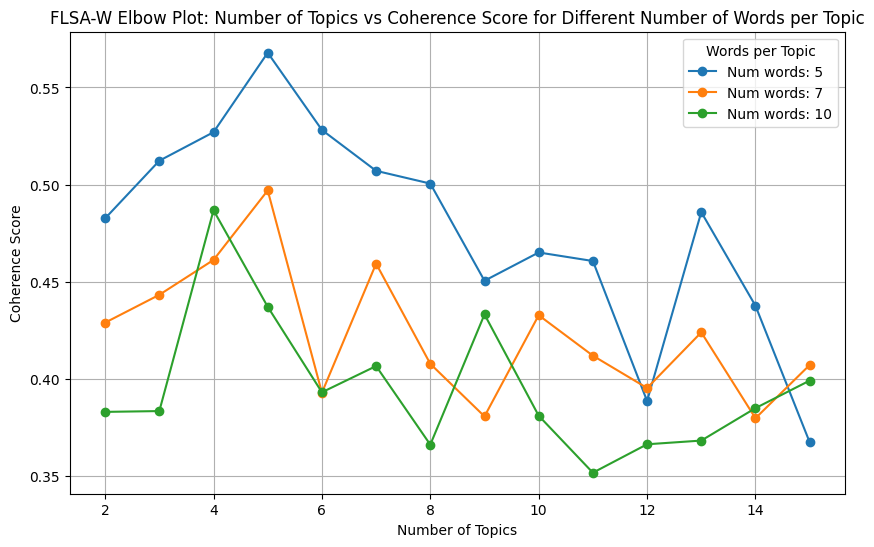

In [19]:
# Plot the elbow curve
plot_elbow_curve(results)

## Train Topic Models

In [17]:
# the optimal number of topics according to FLSA-W
NUMBER_OF_TOPICS = 5

# Dataset has low lexical richness, so we use a smaller number of words per topic
NUMBER_OF_WORDS_PER_TOPIC = 5

In [ ]:
def train_topic_model(train_data, model_type='LDA', num_topics=NUMBER_OF_TOPICS, num_words_per_topic=NUMBER_OF_WORDS_PER_TOPIC, preprocess=False, top_percent=0, bottom_percent=0, words_to_exclude=None, use_bigrams=False):
    """
    Train a topic model on the given training data.

    Parameters:
    - train_data: dict, the text to train the model on with key 'preprocessed_content'
    - model_type: str, the type of model to train ('LDA', 'FLSA-W', 'BERTopic')
    - num_topics: int, the number of topics to use for the model
    - num_words_per_topic: int, the number of words per topic to use for the model
    - preprocess: bool, whether to preprocess the data using remove_top_bottom_words
    - top_percent: int, the top n% of words to remove based on frequency
    - bottom_percent: int, the bottom n% of words to remove based on frequency    
    - words_to_exclude: list of str, specific words to exclude from the data
    - use_bigrams: bool, whether to include bigrams in the data

    Returns:
    - model: the trained model
    - topics: the topics generated by the model
    - bigrams: the bigrams created (if any)
    """

    train_data_list_tokens = train_data['preprocessed_content']
    bigrams = None

    if preprocess:
        train_data_list_tokens = remove_top_bottom_words(
            train_data_list_tokens,
            top_percent=top_percent,
            bottom_percent=bottom_percent,
            words_to_exclude=words_to_exclude
        )

    if use_bigrams:
        # Detect bigrams in the tokenized text data
        bigram = Phrases(train_data_list_tokens, 
                         min_count=5, # min number of times a bigram must appear in the corpus to be considered a phrase
                         threshold=90) # scoring threshold for forming phrases based on the likelihood of the words appearing together versus separately.
        train_data_list_tokens = [bigram[doc] for doc in train_data_list_tokens]
        bigrams = bigram

    # Filter out empty lists
    train_data_list_tokens = [tokens for tokens in train_data_list_tokens if tokens]

    if model_type == 'LDA':
        # Create Gensim dictionary
        dictionary = corpora.Dictionary(train_data_list_tokens)

        # Remove very common and very rare words from dictionary
        dictionary.filter_extremes(no_below=0.5, no_above=0.5)    

        # Create Document-Term Matrix
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_data_list_tokens]

        lda_model = gensim.models.LdaModel(
            doc_term_matrix,
            num_topics=num_topics,
            id2word=dictionary,
            random_state=42,
            passes=5,
            alpha='auto'
        )

        # Get topics (top words in each topic)
        topics = lda_model.print_topics(num_words=num_words_per_topic)

        return lda_model, topics, bigrams, train_data_list_tokens, dictionary

    elif model_type == 'FLSA-W':
        flsa_w_model = FLSA_W(
            input_file=train_data_list_tokens,
            num_topics=num_topics,
            num_words=num_words_per_topic
        )
        pwgt, ptgd = flsa_w_model.get_matrices()  # This trains the model
        topics = flsa_w_model.show_topics(representation='words')

        return flsa_w_model, topics, bigrams
    
    elif model_type == 'BERTopic':
        # Train BERTopic model
        topic_model = BERTopic()
        topics, _ = topic_model.fit_transform(train_data_list_tokens)

        return topic_model, topics, bigrams, train_data_list_tokens, dictionary

    else:
        raise ValueError("Invalid model_type. Choose from 'LDA', 'FLSA-W', 'BERTopic'.")

## Iteration 1

### LDA

In [31]:
# Set seed for reproducible results
np.random.seed(42)

LDA_model, LDA_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(train_data_v1, model_type='LDA')

print_most_common_bigrams(bigrams, train_data_v1['preprocessed_content'], top_n=15)

# Set up topics in the correct format for CoherenceModel
lda_topics = [[word for word, _ in LDA_model.show_topic(topic_id, topn=10)] for topic_id in range(LDA_model.num_topics)]

# Call the modified evaluation function
lda_print_evaluation_metrics(LDA_model, train_data_list_tokens, dictionary)

No bigrams were created.


LDA Topics with Word Probabilities:

Topic 1: 0.007*"week" + 0.006*"p" + 0.005*"0" + 0.005*"u" + 0.005*"index" + 0.005*"500" + 0.005*"investors" + 0.004*"trade" + 0.004*"i" + 0.004*"day"
Topic 2: 0.018*"million" + 0.013*"0" + 0.013*"revenues" + 0.010*"inc" + 0.008*"share" + 0.007*"consensus" + 0.007*"per" + 0.006*"cents" + 0.006*"8" + 0.006*"were"
Topic 3: 0.008*"intel" + 0.006*"amd" + 0.006*"rank" + 0.005*"industry" + 0.004*"data" + 0.004*"our" + 0.004*"ai" + 0.004*"gaming" + 0.004*"these" + 0.004*"semiconductor"
Topic 4: 0.009*"rank" + 0.008*"investment" + 0.006*"research" + 0.006*"our" + 0.006*"estimate" + 0.005*"these" + 0.005*"analyst" + 0.005*"consensus" + 0.005*"positive" + 0.004*"per"
Topic 5: 0.009*"i" + 0.009*"said" + 0.006*"u" + 0.005*"they" + 0.005*"percent" + 0.004*"their" + 0.004*"t" + 0.004*"china" + 0.004*"so" + 0.004*"he"

Vocabulary size: 12,291

Coherence Score: 0.4618


### FLSA-W

In [25]:
# Set seed for reproducible results
np.random.seed(42)

# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics, bigrams = train_topic_model(train_data_v1, 
                                                         model_type='FLSA-W')

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_v1['preprocessed_content'], top_n=15)

# Print evaluation metrics for the FLSA-W model
flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics)

No bigrams were created.


FLSA-W Topics with Word Probabilities:

(0, '0.0004*"gmt" + 0.0003*"rises" + 0.0003*"the" + 0.0003*"to" + 0.0003*"in"')
(1, '0.0017*"nvda" + 0.0017*"nvidia" + 0.0015*"com" + 0.0015*"2017" + 0.0015*"nasdaq"')
(2, '0.0002*"the" + 0.0002*"to" + 0.0002*"in" + 0.0002*"of" + 0.0002*"a"')
(3, '0.0083*"book" + 0.0073*"evolution" + 0.0071*"books" + 0.0066*"richard" + 0.0063*"science"')
(4, '0.0007*"reuters" + 0.0006*"traded" + 0.0006*"exchange" + 0.0006*"chipmaker" + 0.0005*"previously"')


FLSA-W Topics:

Topic 1: gmt, rises, the, to, in
Topic 2: nvda, nvidia, com, 2017, nasdaq
Topic 3: the, to, in, of, a
Topic 4: book, evolution, books, richard, science
Topic 5: reuters, traded, exchange, chipmaker, previously

Vocabulary size: 36,322

Coherence Score: 0.5883
Diversity Score: 0.88
Interpretability Score: 0.5177


### BERTopic

In [ ]:
# Train BERTopic model on the first version of the preprocessed dataset
bertopic_model, bertopic_topics, bigrams, train_data_tokens_list, dictionary = train_topic_model(train_data_v1, model_type='BERTopic')

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_v1['preprocessed_content'], top_n=15)

# Evaluation metrics of the BERTopic model
bertopic_print_evaluation_metrics(bertopic_model, bertopic_topics, train_data_tokens_list, dictionary)

## Iteration 2

### LDA

In [61]:
# Set seed for reproducible results
np.random.seed(42)

LDA_model, LDA_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(
    train_data_v2, 
    model_type='LDA', 
    preprocess=True, 
    top_percent=2,
    bottom_percent=2,
    #words_to_exclude={'u', 'p', 'amd', 'inc', 'etf', 'q'} TODO Higher coherence without removing these...
    )

print_most_common_bigrams(bigrams, train_data_v1['preprocessed_content'], top_n=15)

# Set up topics in the correct format for CoherenceModel
lda_topics = [[word for word, _ in LDA_model.show_topic(topic_id, topn=10)] for topic_id in range(LDA_model.num_topics)]

# Call the modified evaluation function
lda_print_evaluation_metrics(LDA_model, train_data_list_tokens, dictionary)

No bigrams were created.


LDA Topics with Word Probabilities:

Topic 1: 0.004*"herein" + 0.003*"engage" + 0.003*"highlights" + 0.003*"material" + 0.003*"profitable" + 0.003*"whole" + 0.003*"subject" + 0.003*"actual" + 0.003*"zero" + 0.002*"podcast"
Topic 2: 0.002*"uber" + 0.002*"dma" + 0.002*"vix" + 0.002*"baidu" + 0.002*"mobileye" + 0.002*"n" + 0.001*"auto" + 0.001*"jobs" + 0.001*"say" + 0.001*"work"
Topic 3: 0.004*"cards" + 0.003*"sma" + 0.003*"radeon" + 0.003*"datacenter" + 0.003*"processor" + 0.003*"geforce" + 0.002*"ryzen" + 0.002*"gamers" + 0.002*"streaming" + 0.002*"crypto"
Topic 4: 0.004*"gmt" + 0.003*"lowest" + 0.003*"et" + 0.002*"seven" + 0.002*"usd" + 0.002*"traders" + 0.002*"yields" + 0.002*"talks" + 0.002*"central" + 0.002*"meeting"
Topic 5: 0.002*"acquisitions" + 0.002*"outperforming" + 0.002*"netapp" + 0.002*"western" + 0.002*"trailing" + 0.002*"sporting" + 0.002*"prospects" + 0.002*"pure" + 0.002*"mellanox" + 0.002*"robotics"

Vocabulary size: 30,853

Coherence Score: 

### FLSA-W

In [27]:
# Set seed for reproducible results
np.random.seed(42)

# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics, bigrams = train_topic_model(train_data_v2, 
                                                model_type='FLSA-W', 
                                                preprocess=True, 
                                                words_to_exclude={'gmt', 'inc', 'com', 'whileolympusshares', 'upnoteus'})

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_v2['preprocessed_content'], top_n=15)

# Print evaluation metrics for the FLSA-W model
flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics)

No bigrams were created.


FLSA-W Topics with Word Probabilities:

(0, '0.0015*"advanced" + 0.0015*"intc" + 0.0015*"broader" + 0.0015*"nasdaq" + 0.0015*"rank"')
(1, '0.0002*"" + 0.0002*"premarket" + 0.0002*"nasdaq" + 0.0002*"also" + 0.0002*"market"')
(2, '0.0008*"traded" + 0.0007*"reuters" + 0.0007*"worst" + 0.0006*"previously" + 0.0006*"composite"')
(3, '0.0102*"book" + 0.0092*"evolution" + 0.0087*"books" + 0.0083*"richard" + 0.0079*"science"')
(4, '0.0004*"outnumbered" + 0.0004*"performers" + 0.0003*"settle" + 0.0003*"slumped" + 0.0003*"rises"')


FLSA-W Topics:

Topic 1: advanced, intc, broader, nasdaq, rank
Topic 2: , premarket, nasdaq, also, market
Topic 3: traded, reuters, worst, previously, composite
Topic 4: book, evolution, books, richard, science
Topic 5: outnumbered, performers, settle, slumped, rises

Vocabulary size: 32,132

Coherence Score: 0.5326
Diversity Score: 0.96
Interpretability Score: 0.5113


### BERTopic

In [ ]:
# Train BERTopic model on the second version of the preprocessed dataset
bertopic_model, bertopic_topics, bigrams, train_data_tokens_list, dictionary = train_topic_model(train_data_v2, model_type='BERTopic')

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_v2['preprocessed_content'], top_n=15)

# Evaluation metrics of the BERTopic model
bertopic_print_evaluation_metrics(bertopic_model, bertopic_topics, train_data_tokens_list, dictionary)

## Iteration 3

### LDA

In [ ]:
# Set seed for reproducible results
np.random.seed(42)

# TODO: lower coherence then iteration 2....
LDA_model, LDA_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(
    train_data_v3, 
    model_type='LDA', 
    preprocess=True,
    words_to_exclude={'amd', 'inc', 'etf', 'sma', 'et', 'gmt', 'dma', 'baidu', 'radeon', 'vix'},
    top_percent=2,
    bottom_percent=2
    )

print_most_common_bigrams(bigrams, train_data_v1['preprocessed_content'], top_n=15)

# Call the modified evaluation function
lda_print_evaluation_metrics(LDA_model, train_data_list_tokens, dictionary)

No bigrams were created.


LDA Topics with Word Probabilities:

Topic 1: 0.003*"lowest" + 0.002*"seven" + 0.002*"worst" + 0.002*"weekly" + 0.002*"falling" + 0.002*"february" + 0.002*"barrel" + 0.002*"technical" + 0.002*"scenario" + 0.002*"policy"
Topic 2: 0.003*"mining" + 0.003*"approximately" + 0.003*"cadence" + 0.003*"semi" + 0.002*"prior" + 0.002*"ryzen" + 0.002*"instrument" + 0.002*"crypto" + 0.002*"primarily" + 0.002*"sure"
Topic 3: 0.002*"partner" + 0.002*"capability" + 0.002*"experience" + 0.002*"ibm" + 0.002*"develop" + 0.002*"uber" + 0.002*"electronics" + 0.002*"samsung" + 0.002*"working" + 0.002*"deep"
Topic 4: 0.004*"advice" + 0.003*"herein" + 0.003*"engage" + 0.003*"profitable" + 0.002*"subject" + 0.002*"actual" + 0.002*"delivered" + 0.002*"legal" + 0.002*"whole" + 0.002*"resource"
Topic 5: 0.003*"euro" + 0.003*"huawei" + 0.003*"europe" + 0.002*"germany" + 0.002*"softbank" + 0.002*"hong" + 0.002*"kong" + 0.002*"central" + 0.002*"climbed" + 0.002*"treasury"

Vocabulary size:

### FLSA-W

In [29]:
# Set seed for reproducible results
np.random.seed(42)

# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics, bigrams = train_topic_model(train_data_v3, 
                                                model_type='FLSA-W', 
                                                preprocess=True, 
                                                words_to_exclude={'gmt', 'inc', 'com', 'whileolympusshares', 'upnoteus', 'googl', 'amat', 'et'})

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_v2['preprocessed_content'], top_n=15)

# Print evaluation metrics for the FLSA-W model
flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics)

No bigrams were created.


FLSA-W Topics with Word Probabilities:

(0, '0.0002*"premarket" + 0.0002*"company" + 0.0002*"market" + 0.0002*"also" + 0.0002*"nasdaq"')
(1, '0.001*"traded" + 0.0008*"reuters" + 0.0008*"composite" + 0.0008*"worst" + 0.0007*"lowest"')
(2, '0.0004*"outnumbered" + 0.0004*"settle" + 0.0004*"performer" + 0.0004*"slumped" + 0.0003*"dax"')
(3, '0.0018*"nasdaq" + 0.0018*"rank" + 0.0018*"advanced" + 0.0017*"intc" + 0.0017*"during"')
(4, '0.0127*"book" + 0.0105*"evolution" + 0.0091*"richard" + 0.0081*"certainty" + 0.008*"mind"')


FLSA-W Topics:

Topic 1: premarket, company, market, also, nasdaq
Topic 2: traded, reuters, composite, worst, lowest
Topic 3: outnumbered, settle, performer, slumped, dax
Topic 4: nasdaq, rank, advanced, intc, during
Topic 5: book, evolution, richard, certainty, mind

Vocabulary size: 29,068

Coherence Score: 0.5549
Diversity Score: 0.96
Interpretability Score: 0.5327


### BERTopic

In [ ]:
# Train BERTopic model on the third version of the preprocessed dataset
bertopic_model, bertopic_topics, bigrams, train_data_tokens_list, dictionary = train_topic_model(train_data_v3, model_type='BERTopic')

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_v3['preprocessed_content'], top_n=15)

# Evaluation metrics of the BERTopic model
bertopic_print_evaluation_metrics(bertopic_model, bertopic_topics, train_data_tokens_list, dictionary)

## Iteration 4

### LDA

In [63]:
# Set seed for reproducible results
np.random.seed(42)

LDA_model, LDA_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(
    train_data_v3, 
    model_type='LDA', 
    preprocess=True,
    words_to_exclude={'amd', 'inc', 'etf', 'sma', 'et', 'gmt', 'dma', 'baidu', 'radeon', 'vix'},
    top_percent=2,
    bottom_percent=2,
    use_bigrams=True
    )

print_most_common_bigrams(bigrams, train_data_v1['preprocessed_content'], top_n=15)

# Call the modified evaluation function
lda_print_evaluation_metrics(LDA_model, train_data_list_tokens, dictionary)

Top 15 most common bigrams and respective frequencies:

1 - balance_sheet                  236
2 - federal_reserve                222
3 - goldman_sachs                  218
4 - nothing_herein                 200
5 - legal_accounting               200
6 - rebalanced_monthly             200
7 - morgan_stanley                 184
8 - hong_kong                      163
9 - virtual_reality                156
10- immediate_releasechicago       147
11- pure_genius                    147
12- fast_emerging                  142
13- ray_tracing                    138
14- legal_marijuana                133
15- evp_kevin                      129


LDA Topics with Word Probabilities:

Topic 1: 0.002*"treasury" + 0.002*"july" + 0.002*"meeting" + 0.002*"falling" + 0.002*"amid" + 0.002*"february" + 0.002*"retailer" + 0.002*"dropped" + 0.002*"jumped" + 0.002*"hike"
Topic 2: 0.006*"approximately" + 0.003*"netapp" + 0.003*"delivered" + 0.003*"worst" + 0.003*"primarily" + 0.003*"cadence" + 0.003*"settle" +

### FLSA-W

In [30]:
# Set seed for reproducible results
np.random.seed(42)

# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics, bigrams = train_topic_model(train_data_v3, 
                                                model_type='FLSA-W', 
                                                preprocess=True,
                                                words_to_exclude={'gmt', 'inc', 'com', 'whileolympusshares', 'upnoteus', 'googl', 'amat', 'et'},
                                                use_bigrams=True)

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_v3['preprocessed_content'], top_n=15)

# Print evaluation metrics for the FLSA-W model
flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics)

Top 15 most common bigrams and respective frequencies:

1 - long_term                      1262
2 - wall_street                    1128
3 - data_center                    1128
4 - self_driving                   1084
5 - non_gaap                       858
6 - artificial_intelligence        804
7 - advanced_micro                 689
8 - bottom_line                    620
9 - trade_war                      569
10- united_state                   567
11- dow_jones                      551
12- applied_material               475
13- interest_rate                  427
14- gross_margin                   420
15- industrial_average             414


FLSA-W Topics with Word Probabilities:

(0, '0.0004*"past_seven" + 0.0004*"traded_highest" + 0.0004*"start_session" + 0.0004*"lowest_during" + 0.0004*"exchange_volume"')
(1, '0.011*"book" + 0.009*"science" + 0.0088*"evolution" + 0.007*"certainty" + 0.0069*"modern"')
(2, '0.0008*"traded" + 0.0008*"composite" + 0.0007*"reuters" + 0.0007*"previously" + 0

## Output of Final Topic Model

### LDA

In [67]:
# Iteration 2:

# Set seed for reproducible results
np.random.seed(42)

LDA_model, LDA_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(
    train_data_v2, 
    model_type='LDA', 
    preprocess=True, 
    top_percent=2,
    bottom_percent=2,
    #words_to_exclude={'u', 'p', 'amd', 'inc', 'etf', 'q'} TODO Higher coherence without removing these...
    )

print_most_common_bigrams(bigrams, train_data_v1['preprocessed_content'], top_n=15)

# Set up topics in the correct format for CoherenceModel
lda_topics = [[word for word, _ in LDA_model.show_topic(topic_id, topn=10)] for topic_id in range(LDA_model.num_topics)]

# Call the modified evaluation function
lda_print_evaluation_metrics(LDA_model, train_data_list_tokens, dictionary)

No bigrams were created.


LDA Topics with Word Probabilities:

Topic 1: 0.004*"herein" + 0.003*"engage" + 0.003*"highlights" + 0.003*"material" + 0.003*"profitable" + 0.003*"whole" + 0.003*"subject" + 0.003*"actual" + 0.003*"zero" + 0.002*"podcast"
Topic 2: 0.002*"uber" + 0.002*"dma" + 0.002*"vix" + 0.002*"baidu" + 0.002*"mobileye" + 0.002*"n" + 0.001*"auto" + 0.001*"jobs" + 0.001*"say" + 0.001*"work"
Topic 3: 0.004*"cards" + 0.003*"sma" + 0.003*"radeon" + 0.003*"datacenter" + 0.003*"processor" + 0.003*"geforce" + 0.002*"ryzen" + 0.002*"gamers" + 0.002*"streaming" + 0.002*"crypto"
Topic 4: 0.004*"gmt" + 0.003*"lowest" + 0.003*"et" + 0.002*"seven" + 0.002*"usd" + 0.002*"traders" + 0.002*"yields" + 0.002*"talks" + 0.002*"central" + 0.002*"meeting"
Topic 5: 0.002*"acquisitions" + 0.002*"outperforming" + 0.002*"netapp" + 0.002*"western" + 0.002*"trailing" + 0.002*"sporting" + 0.002*"prospects" + 0.002*"pure" + 0.002*"mellanox" + 0.002*"robotics"

Vocabulary size: 30,853

Coherence Score: 

### FLSA-W

In [44]:
# Print evaluation metrics for the FLSA-W model
flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics)



FLSA-W Topics with Word Probabilities:

(0, '0.0003*"worst_performer" + 0.0003*"original_post" + 0.0003*"slumped" + 0.0003*"philadelphia_semiconductor" + 0.0003*"sell_rated"')
(1, '0.0004*"past_seven" + 0.0004*"traded_highest" + 0.0004*"start_session" + 0.0004*"lowest_during" + 0.0004*"exchange_volume"')
(2, '0.0008*"traded" + 0.0008*"composite" + 0.0007*"reuters" + 0.0007*"previously" + 0.0007*"president_donald"')
(3, '0.0018*"corporation" + 0.0017*"rank" + 0.0017*"intc" + 0.0017*"broader" + 0.0016*"nasdaq"')
(4, '0.011*"book" + 0.009*"science" + 0.0088*"evolution" + 0.007*"certainty" + 0.0069*"modern"')


FLSA-W Topics:

Topic 1: worst_performer, original_post, slumped, philadelphia_semiconductor, sell_rated
Topic 2: past_seven, traded_highest, start_session, lowest_during, exchange_volume
Topic 3: traded, composite, reuters, previously, president_donald
Topic 4: corporation, rank, intc, broader, nasdaq
Topic 5: book, science, evolution, certainty, modern

Vocabulary size: 31,596



Topic 0: {'worst_performer': 0.3, 'original_post': 0.3, 'slumped': 0.3, 'philadelphia_semiconductor': 0.3, 'sell_rated': 0.3}


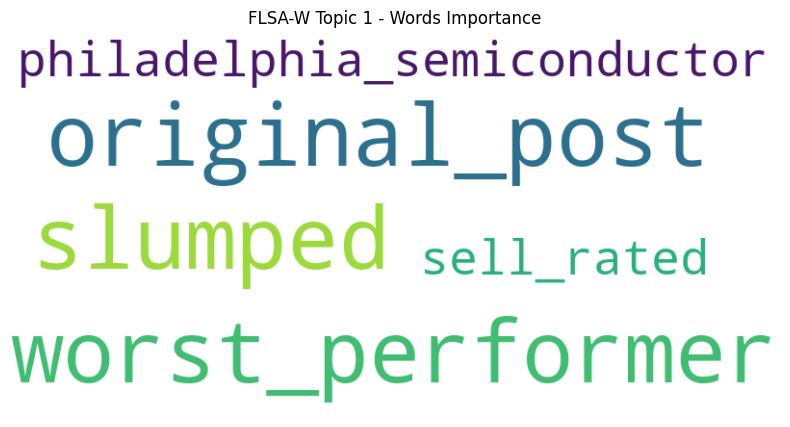

Topic 1: {'past_seven': 0.4, 'traded_highest': 0.4, 'start_session': 0.4, 'lowest_during': 0.4, 'exchange_volume': 0.4}


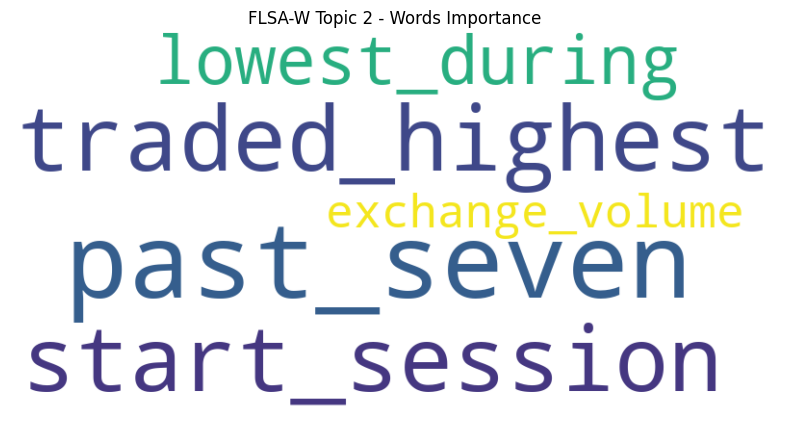

Topic 2: {'traded': 0.8, 'composite': 0.8, 'reuters': 0.7, 'previously': 0.7, 'president_donald': 0.7}


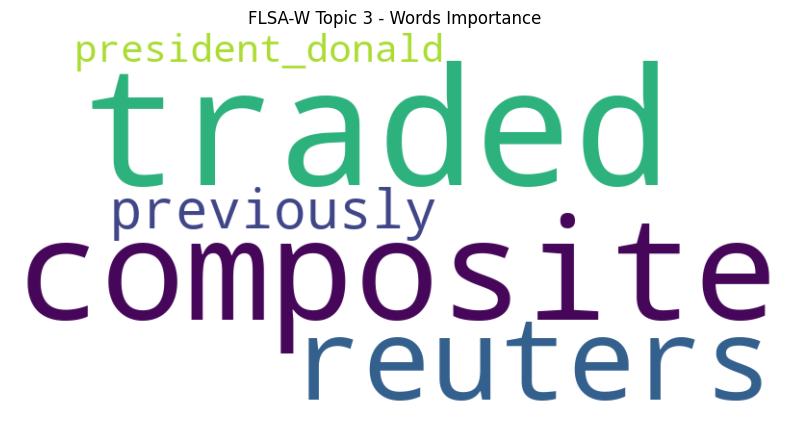

Topic 3: {'corporation': 1.8, 'rank': 1.7, 'intc': 1.7, 'broader': 1.7, 'nasdaq': 1.6}


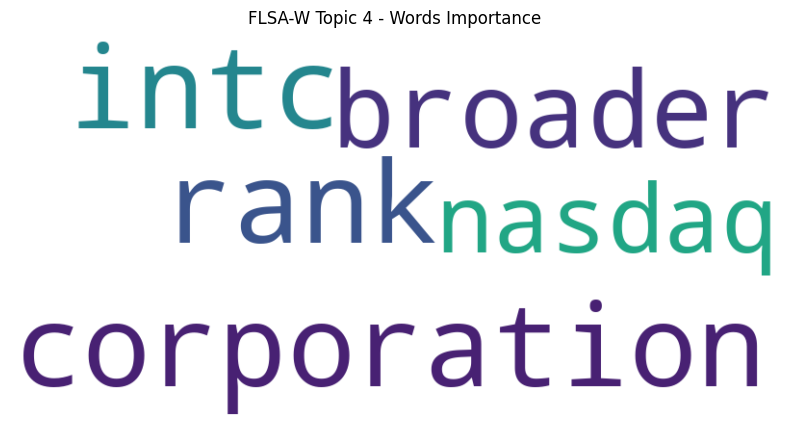

Topic 4: {'book': 11.0, 'science': 9.0, 'evolution': 8.8, 'certainty': 7.0, 'modern': 6.8999999999999995}


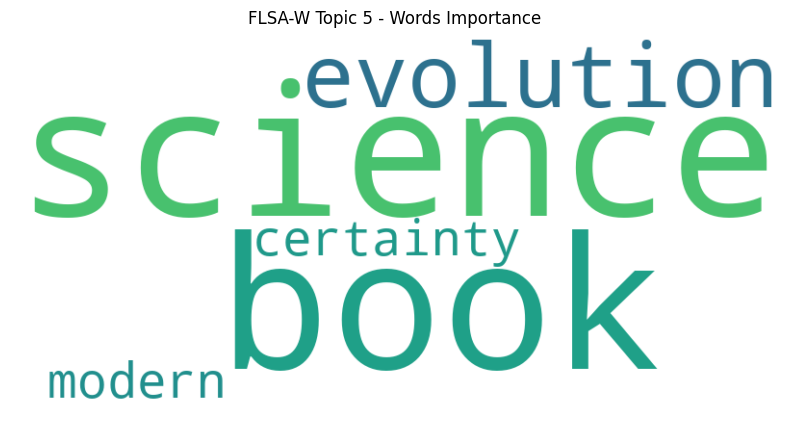

In [79]:
# Get the topics from the model
topic_tuples = flsa_w_model.show_topics()

# Plot Topic-Words Importance
plot_topic_words_importance(topic_tuples)

### BERTopic

In [ ]:
# Evaluation metrics of the final BERTopic model
bertopic_print_evaluation_metrics(bertopic_model, bertopic_topics, train_data_tokens_list, dictionary)

Topic Similarity Matrix

In [ ]:
bertopic_model.visualize_heatmap()